In [302]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt

In [287]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

print(train.shape)
print(test.shape)

(8068, 11)
(2627, 11)


In [288]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [289]:
test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,B
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,A
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,A
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,B
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,A


In [290]:
train.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [291]:
test.isnull().sum()

ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
Segmentation         0
dtype: int64

In [292]:
# Drop ID column (not useful for ML)
train.drop("ID", axis=1, inplace=True)
test.drop("ID", axis=1, inplace=True)

In [293]:
def impute_missing(df):
    for col in df.columns:
        if df[col].dtype == "object":  # categorical
            if not df[col].mode().empty:   # check mode exists
                df[col] = df[col].fillna(df[col].mode()[0])
        else:  # numerical
            df[col] = df[col].fillna(df[col].median())
    return df

train = impute_missing(train)
test = impute_missing(test)

In [294]:
# Encode Categorical Variables (NO test leakage)
cat_cols = train.select_dtypes(include=["object"]).columns.tolist()
if "Segmentation" in cat_cols:
    cat_cols.remove("Segmentation")

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])  # Only transform, do not fit on test
    le_dict[col] = le

# Encode target variable (fit only on train)
le_target = LabelEncoder()
train["Segmentation"] = le_target.fit_transform(train["Segmentation"])
test["Segmentation"] = le_target.transform(test["Segmentation"])

In [295]:
# Train/Val Split
X = train.drop("Segmentation", axis=1)
y = train["Segmentation"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [296]:
# Define Models & Hyperparameters
# -------------------------------
models = {
    "RandomForest": RandomForestClassifier(random_state=42, class_weight="balanced"),
    "XGBoost": XGBClassifier(random_state=42, eval_metric="mlogloss"),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
}

param_grids = {
    "RandomForest": {"n_estimators": [200, 500],
                     "max_depth": [10, 20, None],
                     "min_samples_split": [2, 5]},
    "XGBoost": {"n_estimators": [200, 500],
                "max_depth": [4, 6],
                "learning_rate": [0.05, 0.1],
                "subsample": [0.8, 1],
                "colsample_bytree": [0.8, 1]},
    "CatBoost": {"iterations": [300, 500],
                 "depth": [4, 6],
                 "learning_rate": [0.05, 0.1]}
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

In [ ]:
# Train Models with RandomizedSearchCV
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    grid = RandomizedSearchCV(
        model,
        param_distributions=param_grids[model_name],
        n_iter=5,
        cv=cv,
        scoring="f1_macro",
        n_jobs=1,
        verbose=1,
        random_state=42
    )
    
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    joblib.dump(best_model, f"{model_name}_best_model.pkl")
    
    y_val_pred = best_model.predict(X_val)
    results[model_name] = {
        "val_acc": accuracy_score(y_val, y_val_pred),
        "val_f1": f1_score(y_val, y_val_pred, average="macro"),
        "best_params": grid.best_params_
    }
    
    print(f"Best Params: {grid.best_params_}")
    print("Validation Report:\n", classification_report(y_val, y_val_pred))


Training RandomForest...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 10}
Validation Report:
               precision    recall  f1-score   support

           0       0.43      0.42      0.42       394
           1       0.44      0.38      0.41       372
           2       0.58      0.57      0.57       394
           3       0.64      0.74      0.69       454

    accuracy                           0.54      1614
   macro avg       0.52      0.53      0.52      1614
weighted avg       0.53      0.54      0.53      1614


Training XGBoost...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params: {'subsample': 1, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1}
Validation Report:
               precision    recall  f1-score   support

           0       0.44      0.43      0.44       394
           1       0.44      0.34      0.38       372
      

In [298]:
# Select Best Model & Retrain on Full Training Data
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

best_model_name = max(results, key=lambda x: results[x]['val_f1'])
best_params = results[best_model_name]['best_params']
print(f"\nBest Model: {best_model_name} with params {best_params}")

if best_model_name == "RandomForest":
    final_model = RandomForestClassifier(random_state=42, **best_params)
elif best_model_name == "XGBoost":
    final_model = XGBClassifier(random_state=42, eval_metric="mlogloss",
                                use_label_encoder=False, **best_params)
elif best_model_name == "CatBoost":
    final_model = CatBoostClassifier(random_state=42, verbose=0, **best_params)

final_model.fit(X_full_train, y_full_train)


Best Model: CatBoost with params {'learning_rate': 0.05, 'iterations': 300, 'depth': 4}



Test Set Evaluation:
Accuracy: 0.33840883136657784
Macro F1: 0.3264157368381135
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.30      0.33       846
           1       0.26      0.23      0.24       550
           2       0.26      0.33      0.29       472
           3       0.43      0.46      0.44       759

    accuracy                           0.34      2627
   macro avg       0.33      0.33      0.33      2627
weighted avg       0.34      0.34      0.34      2627



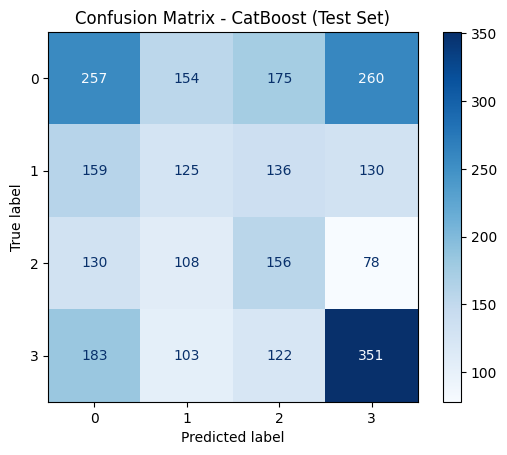

In [303]:
# Separate features and target in test set
X_test = test.drop("Segmentation", axis=1)
y_test = test["Segmentation"]

# Predict & Evaluate on Test Set
y_test_pred = final_model.predict(X_test)

print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Macro F1:", f1_score(y_test, y_test_pred, average="macro"))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name} (Test Set)")
plt.show()
